I just tried using bert, bet I couldn't get better results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, RobertaTokenizer
from tensorflow.keras.optimizers import Adam, SGD

from transformers import TFBertModel
from transformers import BertTokenizer

from transformers import TFXLNetModel, XLNetTokenizer

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [3]:
train_ = pd.read_csv("Lyrics-Genre-Train.csv")
test_ =  pd.read_csv("Lyrics-Genre-Test-GroundTruth.csv")

In [4]:
def conv_labels(data):

    
    numeric_labels=[]

    for i in range(0, len(data.index)):

        if data.Genre[i] == 'Metal':
            numeric_labels.append(0)

        if data.Genre[i] == 'Hip-Hop':
            numeric_labels.append(1)

        if data.Genre[i] == 'Country':
            numeric_labels.append(2)

        if data.Genre[i] == 'Jazz':
            numeric_labels.append(3)

        if data.Genre[i] == 'Electronic':
            numeric_labels.append(4)

        if data.Genre[i] == 'Pop':
            numeric_labels.append(5)

        if data.Genre[i] == 'Folk':
            numeric_labels.append(6)

        if data.Genre[i] == 'Rock':
            numeric_labels.append(7)

        if data.Genre[i] == 'R&B':
            numeric_labels.append(8)

        if data.Genre[i] == 'Indie':
            numeric_labels.append(9)
            
    return numeric_labels

In [5]:
numeric_labels = conv_labels(train_)
numeric_labels1 = conv_labels(test_)

train = pd.DataFrame({'text':train_['Lyrics'], 'class':numeric_labels})
test = pd.DataFrame({'text':test_['Lyrics'], 'class':numeric_labels1})   

In [6]:
train.head()

,text,class
0,"I am a night in to the darkness, only soul los...",0
1,"Yeah\nSometimes, i just wanna fly away.\nThey ...",1
2,Do you work hard?\nDo you work hard?\nYou don'...,0
3,You know what? I'm destined to be the last man...,1
4,There ain't nothing that I would rather see\nT...,2


In [9]:
def bert_encode(data) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data.text)):
        encoded = tokenizer.encode_plus(
        
        data.text[i],
        add_special_tokens=True,
        max_length=60,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [10]:
train_input_ids,train_attention_masks = bert_encode(train[:50000])
test_input_ids,test_attention_masks = bert_encode(test[:20000])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
E:\Anaconda\lib\site-packages\transformers\tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
    
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1, activation='relu')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [13]:
model = create_model(bert_model)

E:\Anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
u = train[:50000]
targets = u['class'].values

In [15]:
v = test[:20000]
targets_y = v['class'].values

In [ ]:
history = model.fit([train_input_ids,train_attention_masks], targets, validation_data=([test_input_ids,test_attention_masks],targets_y), epochs=4, batch_size = 64)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

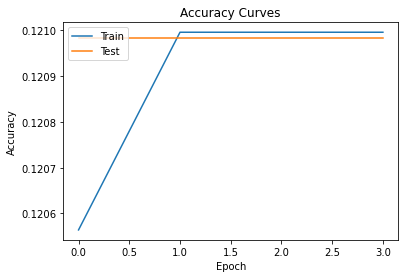

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()